STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.0



# VGG-16 on Cifar-10

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [6]:
##########################
### CIFAR-10 DATASET
##########################

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor()
])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=test_transforms,
    test_transforms=test_transforms,
    num_workers=2)


train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = np.mean(train_mean, axis=0)
train_std = np.mean(train_std, axis=0)

print('Mean:', train_mean)
print('Std Dev:', train_std)

Files already downloaded and verified
Mean: [0.4894929  0.4773143  0.44135574]
Std Dev: [0.23783134 0.23433842 0.25187373]


In [7]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean, train_std)])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize(train_mean, train_std)])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=test_transforms,
    test_transforms=test_transforms,
    num_workers=2)

Files already downloaded and verified


## Model

In [8]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_3 = torch.nn.Sequential(        
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = torch.nn.Sequential(   
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),        
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),            
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),    
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits                                

Epoch: 001/050 | Batch 0000/0175 | Loss: 6.1954
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.0537
Epoch: 001/050 | Train: 19.04% | Validation: 19.04%
Time elapsed: 1.28 min
Epoch: 002/050 | Batch 0000/0175 | Loss: 2.1804
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.7774
Epoch: 002/050 | Train: 40.07% | Validation: 40.78%
Time elapsed: 2.56 min
Epoch: 003/050 | Batch 0000/0175 | Loss: 1.6183
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.4839
Epoch: 003/050 | Train: 52.31% | Validation: 53.04%
Time elapsed: 3.85 min
Epoch: 004/050 | Batch 0000/0175 | Loss: 1.1803
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.3313
Epoch: 004/050 | Train: 58.00% | Validation: 58.04%
Time elapsed: 5.13 min
Epoch: 005/050 | Batch 0000/0175 | Loss: 1.1702
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.1023
Epoch: 005/050 | Train: 66.52% | Validation: 65.48%
Time elapsed: 6.43 min
Epoch: 006/050 | Batch 0000/0175 | Loss: 0.8781
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.8231
Epoch: 006/050 | Train: 73.31% | Validation: 71.2

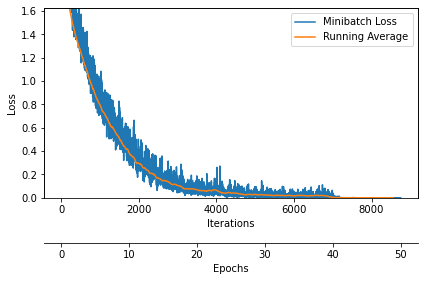

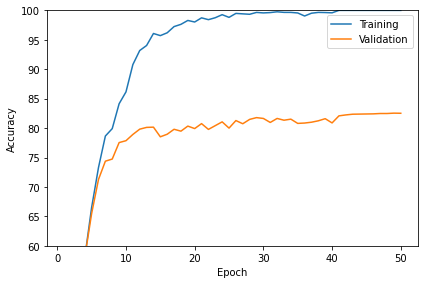

In [9]:
model = VGG16(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

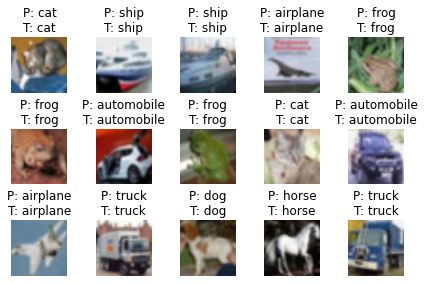

In [12]:
model.cpu()
unnormalizer = UnNormalize(train_mean, train_std)
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

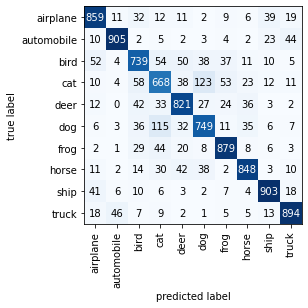

In [13]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()